In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pickle
import pathlib
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cycler import cycler
import numpy as np
from collections import Counter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression


%matplotlib inline

import sys
try:
    sys.path.append('/media/nahuel-ofi/datos/d/Dropbox/doctorado_dbox/software/python/settings')
    from mpl_settings import *
except:
    sys.path.append('/media/nahuel/datos/d/Dropbox/doctorado_dbox/software/python/settings')
    from mpl_settings import *
    
    
fig_dir = '../figs'
net_dir_name = '../networks/ER'

/media/nahuel-ofi/datos/d/anaconda3/envs/networks3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


## Figure 1: Order parameter for different attacks

In [168]:
attacks = ['BtwU', 'DegU', 'Ran', 'Deg', 'Btw']
max_dfs = get_max_dfs(attacks, max_seed=6)

/media/nahuel-ofi/datos/d/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice


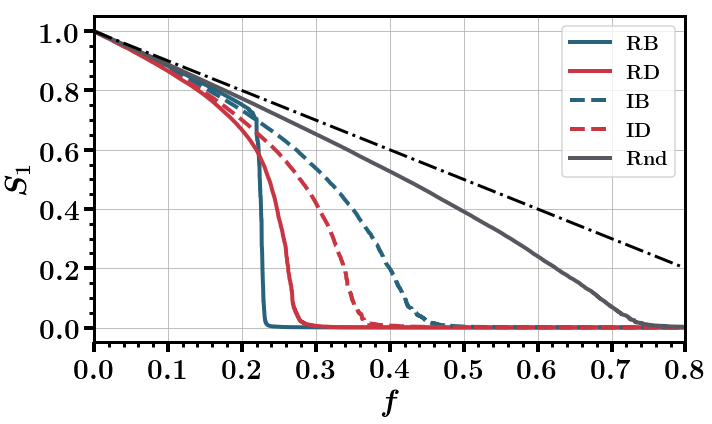

In [169]:
plot_fig_order_param(max_dfs)

## Figure 2: Scaling properties at $f_c$

/media/nahuel-ofi/datos/d/anaconda3/envs/networks3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


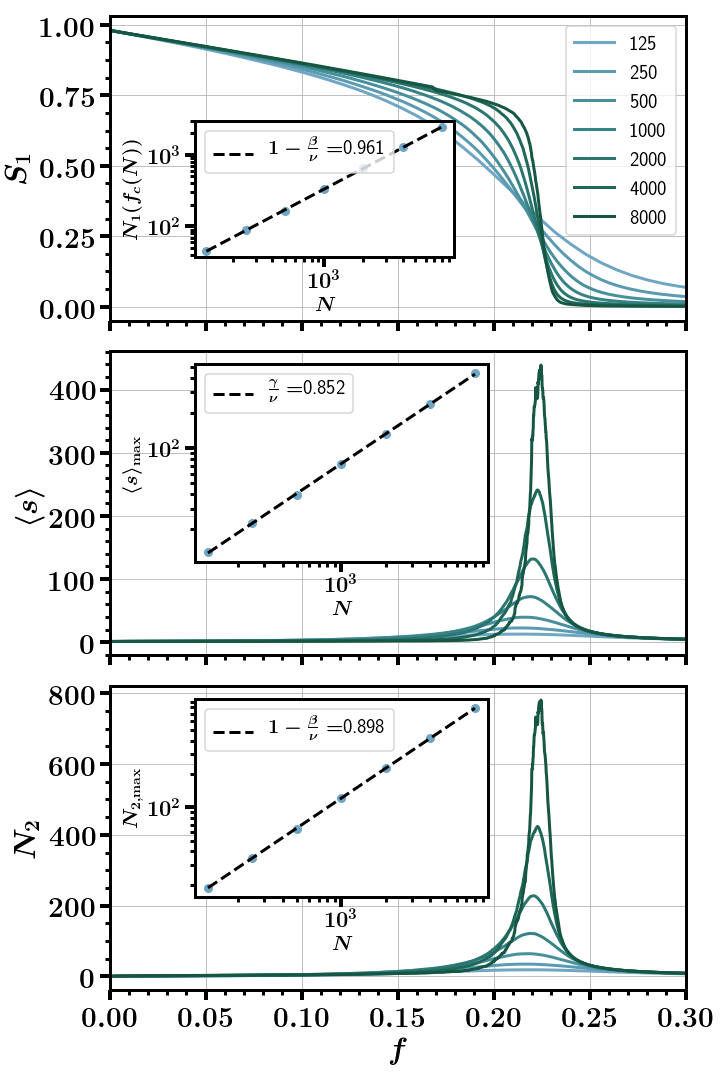

In [17]:
plot_fig2()

## Figure 3: Critical point shifting

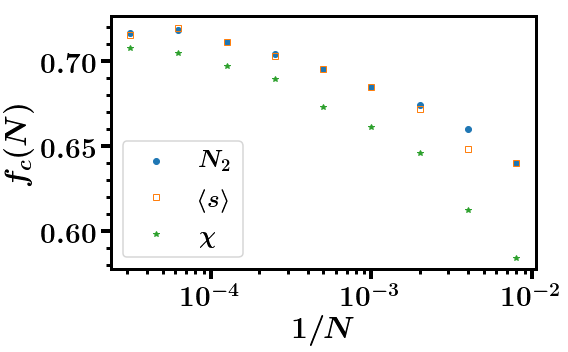

In [73]:
_N_values = N_values
fc_values = {}
measure_fc_values = {}
attack = 'Ran'
measures= ['meanS2', 'Nsec', 'varSgcc']
for measure in measures:
    fc_values[measure], _ = get_fc_N(dfs, attack, _N_values, measure)
    measure_fc_values[measure] = get_crit_measure_N(dfs, attack, _N_values, measure, fc_values[measure])
measure_fc_values['Sgcc'] = get_crit_measure_N(dfs, attack, _N_values, 'Sgcc', fc_values['Nsec'])   

plot_fig3(_N_values, fc_values, attack)

## Figure 4: Cluster size distribution

In [ ]:
attack = 'BtwU'
N = 8000
p = '0.0005'
f_values = ['0.1', '0.2', '0.225', '0.25', '0.3']
f_c = 0.225
all_comp_sizes_dict = {}

base_net_name = 'ER_N{}_p{}'.format(N, p)
base_net_dir_name = os.path.join(net_dir_name, base_net_name)

for f_value in f_values:
    comp_sizes_file = os.path.join(base_net_dir_name, 'comp_sizes_{}_f{}.txt'.format(attack, f_value))
    comp_sizes = np.loadtxt(comp_sizes_file, dtype=int)
    all_comp_sizes_dict[f_value] = comp_sizes
    
plot_fig4(all_comp_sizes_dict, f_c)

## Figure 5: Betweenness distribution

In [ ]:
N = 8000
p = 0.0005
base_net =  'ER_N{}_p{}'.format(N, p)
#f_values = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.21, 0.215, 0.22, 0.225, 0.23,
#            0.24, 0.25, 0.3, 0.35, 0.4, 0.45]
f_values = [0, 0.1, 0.175, 0.2, 0.21, 0.215, 0.22, 0.225, 0.23]

sorted_values = {}
ccdfs = {}
for i, f in enumerate(f_values):
    print(f)
    file_name = "../networks/ER/" + base_net + "/btw_data_" + base_net + "_t{:.6f}.txt".format(f)
    btwSeq = np.loadtxt(file_name)

    mask = btwSeq > 0
    btwSeq = btwSeq[mask]       

    ccdf_name = "../networks/ER/" + base_net + "/btw_ccdf_" + base_net + "_f{:.6f}.npy".format(f)
    if os.path.isfile(ccdf_name):
        sorted_vals, ccdf = np.load(ccdf_name)
    else:
        print(ccdf_name)
        sorted_vals, ccdf = get_ccdf(btwSeq)
        np.save(ccdf_name, np.array([sorted_vals, ccdf]))        
    sorted_values[f] = sorted_vals
    ccdfs[f] = ccdf

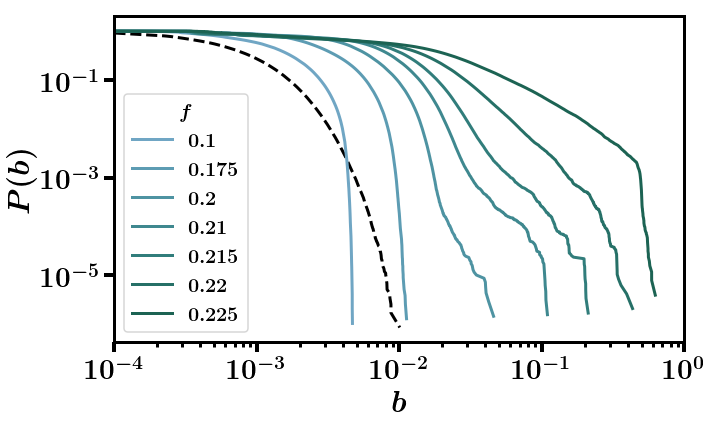

In [19]:
th = 10E-5
plot_fig5(sorted_values, ccdfs, f_values_plot, th)

In [36]:
#attacks = ['BtwU', 'DegU', 'Ran', 'Deg', 'Btw']
attacks = ['Ran']

N_values = [125, 250, 500, 1000, 2000, 4000, 8000, 16000, 32000]
p_values = [0.032, 0.016, 0.008, 0.004, 0.002, 0.001, 0.0005, 0.00025, 0.000125]
#N_values = [32000]
#p_values = [0.000125]
dfs = {}
for attack in attacks:
    dfs[attack] = {}
    for N, p in zip(N_values, p_values):

        network_base = 'ER_N{}_p{}'.format(N, p)
        csv_file_name = os.path.join(net_dir_name, network_base, '{}.csv'.format(attack))    
        df = pd.read_csv(csv_file_name, index_col=0)

        dfs[attack][N] = df

def get_ccdf(data):
    """
    Plot the complementary cumulative distribution function
    (1-CDF(x)) based on the data on the axes object.
    
    Note that this way of computing and plotting the ccdf is not
    the best approach for a discrete variable, where many
    observations can have exactly same value!
    """
    # Note that, here we use the convention for presenting an 
    # empirical 1-CDF (ccdf) as discussed above
    sorted_vals = np.sort(np.unique(data))
    ccdf = np.zeros(len(sorted_vals))
    n = float(len(data))
    for i, val in enumerate(sorted_vals):
        ccdf[i] = np.sum(data >= val)/n
    return sorted_vals, ccdf
        
def get_max_dfs(attacks, max_seed=100):

    Sgcc_values = {}
    N = 16000
    p = 0.00025
    max_dfs = {}
    for attack in attacks:
        Ngcc_values = []

        for seed in range(max_seed):
            network_base = 'ER_N{}_p{}'.format(N, p)
            network = network_base + '_{:05d}'.format(seed)
            attack_dir_name = os.path.join(net_dir_name, network_base, network, attack)

            full_file_name  = os.path.join(attack_dir_name, 'comp_data_' + network + '.txt')
            if not os.path.isfile(full_file_name):
                continue

            aux = np.loadtxt(full_file_name, dtype=float)
            _Ngcc_values = np.append(aux[:,0], np.repeat(np.NaN, (N-len(aux[:,0]))))

            Ngcc_values.append(_Ngcc_values)

        d = {'t': np.arange(N)/N,  'Sgcc': np.nanmean(Ngcc_values, axis=0)/N}
        df = pd.DataFrame(data=d)
        max_dfs[attack] = df
    return max_dfs
        
def plot_fig1(max_dfs):
    
    N = 16000
    ncols = 1
    nrows = 1
    fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

    ax = axes
    ax.grid(True)
    ax.set_ylabel(r'$S_1$')
    ax.set_xlabel(r'$f$')
    X = np.arange(N) / N
    Y1 = max_dfs['BtwU']['Sgcc'] 
    Y2 = max_dfs['DegU']['Sgcc']
    Y3 = max_dfs['Ran']['Sgcc']
    ax.set_xlim(0, 0.8)
    ax.set_xticks(np.arange(0, 0.9, 0.1))
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.plot(X, Y1/Y1[0], label=r'$\mathrm{RB}$', color='#27647b', linewidth=4)
    ax.plot(X, Y2/Y2[0], label=r'$\mathrm{RD}$', color='#ca3542', linewidth=4)
    ax.plot(X, Y3/Y3[0], label=r'$\mathrm{Ran}$', color='#57575f', linewidth=4)
    ax.plot(X, 1 - X, color='k', linestyle='--')
    ax.legend(loc='best')

    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'percolation')
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')
    plt.show()
    
def plot_fig_order_param(max_dfs):
    
    N = 16000
    ncols = 1
    nrows = 1
    fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

    ax = axes
    ax.grid(True)
    ax.set_ylabel(r'$S_1$')
    ax.set_xlabel(r'$f$')
    X = np.arange(N) / N
    Y1 = max_dfs['BtwU']['Sgcc'] 
    Y2 = max_dfs['DegU']['Sgcc']
    Y4 = max_dfs['Btw']['Sgcc'] 
    Y5 = max_dfs['Deg']['Sgcc']
    Y3 = max_dfs['Ran']['Sgcc']
    ax.set_xlim(0, 0.8)
    ax.set_xticks(np.arange(0, 0.9, 0.1))
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.plot(X, Y1/Y1[0], label=r'$\mathrm{RB}$', color='#27647b', linewidth=4)
    ax.plot(X, Y2/Y2[0], label=r'$\mathrm{RD}$', color='#ca3542', linewidth=4)
    ax.plot(X, Y4/Y4[0], label=r'$\mathrm{IB}$', color='#27647b', linewidth=4, linestyle='--')
    ax.plot(X, Y5/Y5[0], label=r'$\mathrm{ID}$', color='#ca3542', linewidth=4, linestyle='--')
    ax.plot(X, Y3/Y3[0], label=r'$\mathrm{Rnd}$', color='#57575f', linewidth=4)
    ax.plot(X, 1 - X, color='k', linestyle='-.')
    ax.legend(loc='best', fontsize=20)

    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'percolation')
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')
    plt.show()
    
    
def get_fc_N(dfs, attack, sizes, measure):

    fcs = []
    peaks = []
    for N in sizes:
        idx = dfs[attack][N][measure].idxmax()    
        fcs.append(idx/N)
        peaks.append(dfs[attack][N][measure][idx])
    return np.array(fcs), np.array(peaks)

def get_crit_measure_N(dfs, attack, sizes, measure, fc_values):
    n_sizes = len(sizes)
    if isinstance(fc_values, float):
        fc_values = [fc_values] * n_sizes
        
    crit_values = []    
    for N, fc in zip(sizes, fc_values):
        if measure == 'Sgcc':
            crit_values.append(N*dfs[attack][N][measure][int(fc*N)])
        else:
            crit_values.append(dfs[attack][N][measure][int(fc*N)])
        
    return np.array(crit_values)  

def getLinearReg(sizes, values):
    linear_regressor = LinearRegression() 
    X = np.log(sizes).reshape(-1, 1)
    Y = np.log(values).reshape(-1, 1)
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    slope = linear_regressor.coef_[0][0]
    return np.exp(Y_pred), slope
    
def plot_inset(_N_values, measure, ax, measure_fc_values):

    Y_pred, slope = getLinearReg(_N_values, measure_fc_values[measure])
    
    if measure == 'Nsec':
        bbox_to_anchor = (.17, .35, .51, .65)
        #bbox_to_anchor = (.17, .35, .4, .5)
        label = r'$1 - \frac{\beta}{\nu} = $' + '{:.3f}'.format(slope)
        #ylabel = r'$N_{2,\mathrm{max}}$'
        ylabel = r'$N_{2c}$'

    if measure == 'meanS2':
        bbox_to_anchor = (.17, .35, .51, .65)
        #bbox_to_anchor = (.17, .35, .4, .5)
        label = r'$\frac{\gamma}{\nu} = $' + '{:.3f}'.format(slope)
        #ylabel = r'$\langle s \rangle_{\mathrm{max}}$'
        ylabel = r'$\langle s \rangle_c$'
        
    if measure == 'Sgcc':
        bbox_to_anchor = (.17, .2, .45, .5)
        #bbox_to_anchor = (.17, .25, .4, .4)
        label = r'$1 - \frac{\beta}{\nu} = $' + '{:.3f}'.format(slope)
        ylabel = r'$N_{1c}$'

    
    axins = inset_axes(ax, width="100%", height="100%",
                       bbox_to_anchor=bbox_to_anchor,
                       bbox_transform=ax.transAxes)
    axins.set_xscale('log')
    axins.set_yscale('log')
    axins.tick_params(which='major', labelsize=22)
    axins.tick_params(which='minor', labelsize=22)
    axins.plot(_N_values, measure_fc_values[measure], 'o', markersize=8)    
    axins.plot(_N_values, Y_pred, '--', color='k', linewidth=3, label=label)
    axins.legend(loc='best', fontsize=20) 
    if measure == 'meanS2':
        axins.set_xlabel(r'$N$', fontsize=20) 
    else:
        axins.set_xlabel('') 
    axins.set_ylabel(ylabel, fontsize=20)  
        
def plot_fig2():

    _N_values = N_values[:-1]
    attack = 'BtwU'
    measures= ['meanS2', 'Nsec']
    peak_values = {}
    fc_values = {}
    measure_fc_values = {}
    for measure in measures:
        fc_values[measure], peak_values[measure] = get_fc_N(dfs, attack, _N_values, measure)
        measure_fc_values[measure] = get_crit_measure_N(dfs, attack, _N_values, measure, fc_values[measure])
    measure_fc_values['Sgcc'] = get_crit_measure_N(dfs, attack, _N_values, 'Sgcc', fc_values['Nsec'])    

    palette = sns.cubehelix_palette(
        n_colors=len(N_values), start=2.0, rot=0.35, gamma=1.0, hue=1.0, light=0.6, dark=0.2,
    )
    plt.rc('axes', prop_cycle=cycler('color', palette))
    
    attack = 'BtwU'

    ncols = 1
    nrows = 3
    fig, axes = plt.subplots(figsize=(10*ncols, 5*nrows), ncols=ncols, nrows=nrows, sharex=True)

    for ax in axes.flatten():
        ax.set_xlim(0., 0.3)
        ax.grid(True)

    ax = axes[0]
    for N in _N_values:
        ax.plot(dfs[attack][N]['t'], dfs[attack][N]['Sgcc'], label='{}'.format(N))
    ax.set_ylabel(r'$S_1$')
    ax.legend(loc='best', fontsize=20)

    ax = axes[1]
    for N in _N_values:
        ax.plot(dfs[attack][N]['t'], dfs[attack][N]['meanS2'])
    ax.set_ylabel(r'$\langle s \rangle $')

    ax = axes[2]
    for N in _N_values:
        ax.plot(dfs[attack][N]['t'], dfs[attack][N]['Nsec'])
    ax.set_ylabel(r'$N_2$')
    ax.set_xlabel(r'$f$')

    plot_inset(_N_values, 'Sgcc', axes[0], measure_fc_values)
    plot_inset(_N_values, 'meanS2', axes[1], measure_fc_values)
    plot_inset(_N_values, 'Nsec', axes[2], measure_fc_values)

    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'fssa_{}_draft'.format(attack))
    plt.savefig(fig_name + '.png', transparent=False)
    plt.savefig(fig_name + '.pdf', transparent=False)
    plt.show()


def plot_fig3(_N_values, fc_values, attack):
    ncols = 1
    nrows = 1
    fig, axes = plt.subplots(figsize=(8*ncols, 5*nrows), ncols=ncols, nrows=nrows)

    ax = axes
    ax.set_xscale('log')
    ax.set_xlabel(r"$1/N$") 
    ax.plot(1/np.array(_N_values), fc_values['Nsec'], 'o', color=colors[0], label=r'$N_{2}$')
    ax.plot(1/np.array(_N_values), fc_values['meanS2'], 's', color=colors[1], 
            label=r"$\langle s \rangle $", markerfacecolor='none')
    ax.plot(1/np.array(_N_values), fc_values['varSgcc'], '*', color=colors[2], 
            label=r"$\chi$")
    ax.set_ylabel(r'$f_c(N)$')
    ax.legend(loc='best', fontsize=24)

    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'fc_{}'.format(attack))
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')
    plt.show()
    

def plot_fig4(all_comp_sizes_dict, f_c):

    fig, ax = plt.subplots(figsize=(8, 5), ncols=1, nrows=1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$s$')
    #ax.set_xlim(0.9, np.max([np.max(elem) for elem in all_comp_sizes_dict[N].values()]))

    ax.set_ylabel(r'$P(s)$')
    for i, f_value in enumerate(f_values):
        f = float(f_value)
        Y = all_comp_sizes_dict[f_value]
        sorted_vals, ccdf = get_ccdf(Y)
        if f < f_c:
            if i == len(f_values)//2 - 1:
                ax.plot(sorted_vals, ccdf, '-.', alpha=0.9, color='#ca3542', label=r'$f < f_c$')
            else:
                ax.plot(sorted_vals, ccdf, '-.', alpha=0.7, color='#ca3542')
        elif f > f_c:
            if i == len(f_values)//2+1:
                ax.plot(sorted_vals, ccdf, '--', alpha=0.9, color='#27647b', label=r'$f > f_c$')
            else:
                ax.plot(sorted_vals, ccdf, '--', alpha=0.7, color='#27647b')

        else:
            ax.plot(sorted_vals, ccdf, '-', color='#57575f', label=r'$f = f_c$')

    legend = ax.legend(loc='best', fontsize=20)
    fig_name = os.path.join(fig_dir, 'comp_size_dist_{}'.format(attack))
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')
    plt.tight_layout()
    plt.show()
    
    
def plot_fig5(sorted_values, ccdfs, f_values_plot, th):

    ncols = 1
    nrows = 1
    fig, ax = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows, sharex=True)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10E-5, 1)

    ax.set_ylabel('$P(b)$')
    ax.set_xlabel('$b$')

    f_values_plot = [0, 0.1, 0.175, 0.2, 0.21, 0.215, 0.22, 0.225]
    palette = sns.cubehelix_palette(
        n_colors=len(f_values_plot)+1, start=2.0, rot=0.35, gamma=1.0, hue=1.0, light=0.6, dark=0.2,
    )
    plt.rc('axes', prop_cycle=cycler('color', palette))

    for f in f_values_plot:
        sorted_vals = sorted_values[f]
        ccdf = ccdfs[f]
        mask = sorted_vals >= th
        if f == 0:
            ax.plot(sorted_vals[mask], ccdf[mask], '--', color='k')
        else:
            ax.plot(sorted_vals[mask], ccdf[mask], '-', label=r'${{{}}}$'.format(f))

    legend = ax.legend(loc='best', title=r'$f$', fontsize=20)
    plt.setp(legend.get_title(),fontsize=20)

    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'btw_CCDF_log')
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')
    plt.show()

In [6]:
N = 8000
p = 0.0005
base_net =  'ER_N{}_p{}'.format(N, p)
f_values = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.21, 0.215, 0.22, 0.225, 0.23,
                0.24, 0.25, 0.3, 0.35, 0.4, 0.45]

f_values = [0, 0.1, 0.175, 0.2, 0.21, 0.215, 0.22, 0.225, 0.23]

maxb_values = []
btw_dist_lin = {}
btw_dist_log = {}
sorted_values = {}
ccdfs = {}
for i, f in enumerate(f_values):
    print(f)
    file_name = "../networks/ER/" + base_net + "/btw_data_" + base_net + "_t{:.6f}.txt".format(f)
    btwSeq = np.loadtxt(file_name)

    mask = btwSeq > 0
    btwSeq = btwSeq[mask]       

    minb = min(btwSeq)
    maxb = max(btwSeq)
    maxb_values.append(maxb)
    
    meanb = np.mean(btwSeq)
    stdb = np.std(btwSeq)
    meanb2 = np.mean(btwSeq**2)

    bins = np.logspace(np.log10(minb), np.log10(maxb), 12)
    hist, bin_edges = np.histogram(btwSeq, bins=bins, density=True)
    bin_centers = (bins[1:] + bins[:-1]) / 2
    widths = np.diff(bins)
    hist_norm = hist/widths
    hist_norm[hist_norm==0] = np.NaN
    mask = np.isfinite(hist_norm)
    btw_dist_log[f] = [bin_centers[mask], hist_norm[mask]]   
    
    bins = np.linspace(minb, maxb, 12)
    hist, bin_edges = np.histogram(btwSeq, bins=bins, density=True)
    bin_centers = (bins[1:] + bins[:-1]) / 2
    widths = np.diff(bins)
    hist_norm = hist/widths
    hist_norm[hist_norm==0] = np.NaN
    mask = np.isfinite(hist_norm)
    btw_dist_lin[f] = [bin_centers[mask], hist_norm[mask]]   
    
    
    ccdf_name = "../networks/ER/" + base_net + "/btw_ccdf_" + base_net + "_f{:.6f}.npy".format(f)
    if os.path.isfile(ccdf_name):
        sorted_vals, ccdf = np.load(ccdf_name)
    else:
        print(ccdf_name)
        sorted_vals, ccdf = get_ccdf(btwSeq)
        np.save(ccdf_name, np.array([sorted_vals, ccdf]))        
    sorted_values[f] = sorted_vals
    ccdfs[f] = ccdf

0
0.1
0.175
0.2
0.21
0.215
0.22
0.225
0.23


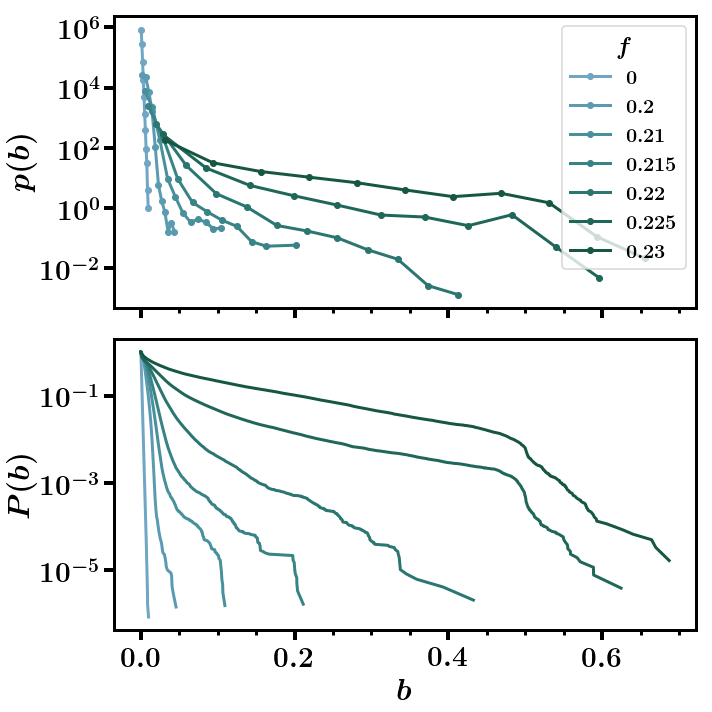

In [109]:
ncols = 1
nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 5*nrows), ncols=ncols, nrows=nrows, sharex=True)
for ax in axes:
    ax.set_yscale('log')
    #ax.set_xscale('log')
    
    #ax.set_xlim(0.0, 0.04)
axes[0].set_ylabel('$p(b)$')
axes[1].set_ylabel('$P(b)$')
axes[1].set_xlabel('$b$')

f_values_plot = [0, 0.2, 0.21, 0.215, 0.22, 0.225, 0.23]
palette = sns.cubehelix_palette(
    n_colors=len(f_values_plot)+1, start=2.0, rot=0.35, gamma=1.0, hue=1.0, light=0.6, dark=0.2,
)
plt.rc('axes', prop_cycle=cycler('color', palette))
    

for f in f_values_plot:

    bin_centers, hist_norm = btw_dist_lin[f]
    axes[0].plot(bin_centers, hist_norm, 'o-', label=r'${{{}}}$'.format(f))
    
    axes[1].plot(sorted_values[f], ccdfs[f], '-', label=r'${{{}}}$'.format(f))

legend = axes[0].legend(loc='best', title=r'$f$', fontsize=20)
plt.setp(legend.get_title(),fontsize=24)

plt.tight_layout()
fig_name = os.path.join(fig_dir, 'btw_dist')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

NameError: name 'btw_dist_lin' is not defined

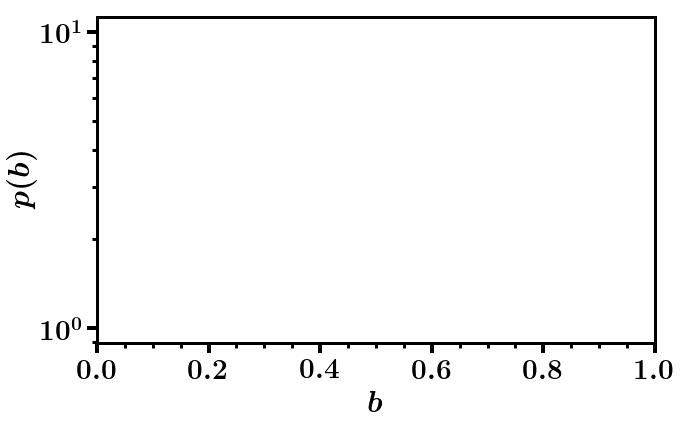

In [4]:
ncols = 1
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)
ax = axes
ax.set_yscale('log')
ax.set_ylabel('$p(b)$')
ax.set_xlabel('$b$')

f_values_plot = [0, 0.2, 0.21, 0.215, 0.22, 0.225]
palette = sns.cubehelix_palette(
    n_colors=len(f_values_plot)+1, start=2.0, rot=0.35, gamma=1.0, hue=1.0, light=0.6, dark=0.2,
)
plt.rc('axes', prop_cycle=cycler('color', palette))

for f in f_values_plot:
    bin_centers, hist_norm = btw_dist_lin[f]
    ax.plot(bin_centers, hist_norm, 'o-', label=r'${{{}}}$'.format(f))

legend = ax.legend(loc='best', title=r'$f$', fontsize=20)
plt.setp(legend.get_title(),fontsize=20)

plt.tight_layout()
fig_name = os.path.join(fig_dir, 'btw_dist')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

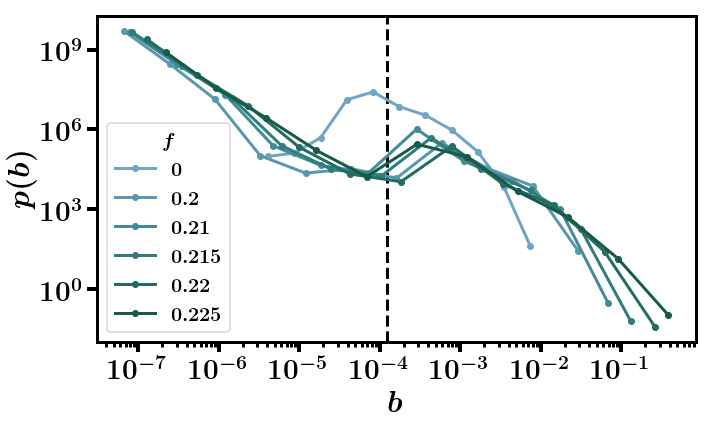

In [131]:
ncols = 1
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)
ax = axes
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$p(b)$')
ax.set_xlabel('$b$')

ax.axvline(1/8000, linestyle='--', color='k')

f_values_plot = [0, 0.2, 0.21, 0.215, 0.22, 0.225]
palette = sns.cubehelix_palette(
    n_colors=len(f_values_plot)+1, start=2.0, rot=0.35, gamma=1.0, hue=1.0, light=0.6, dark=0.2,
)
plt.rc('axes', prop_cycle=cycler('color', palette))

for f in f_values_plot:
    bin_centers, hist_norm = btw_dist_log[f]
    ax.plot(bin_centers, hist_norm, 'o-', label=r'${{{}}}$'.format(f))

legend = ax.legend(loc='best', title=r'$f$', fontsize=20)
plt.setp(legend.get_title(),fontsize=20)

plt.tight_layout()
fig_name = os.path.join(fig_dir, 'btw_dist_log')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

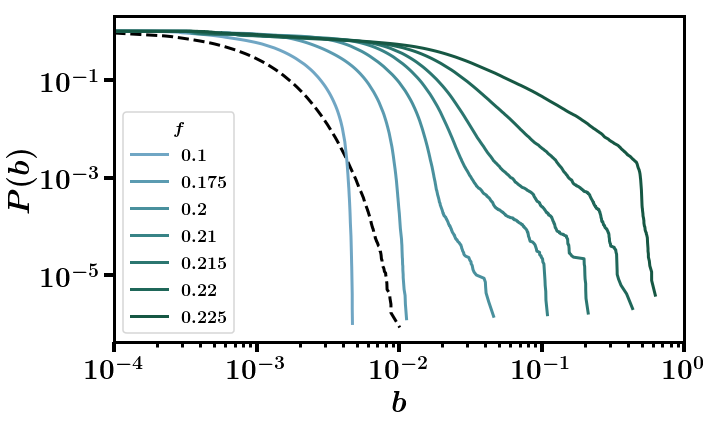

/media/nahuel-ofi/datos/d/anaconda3/envs/networks3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


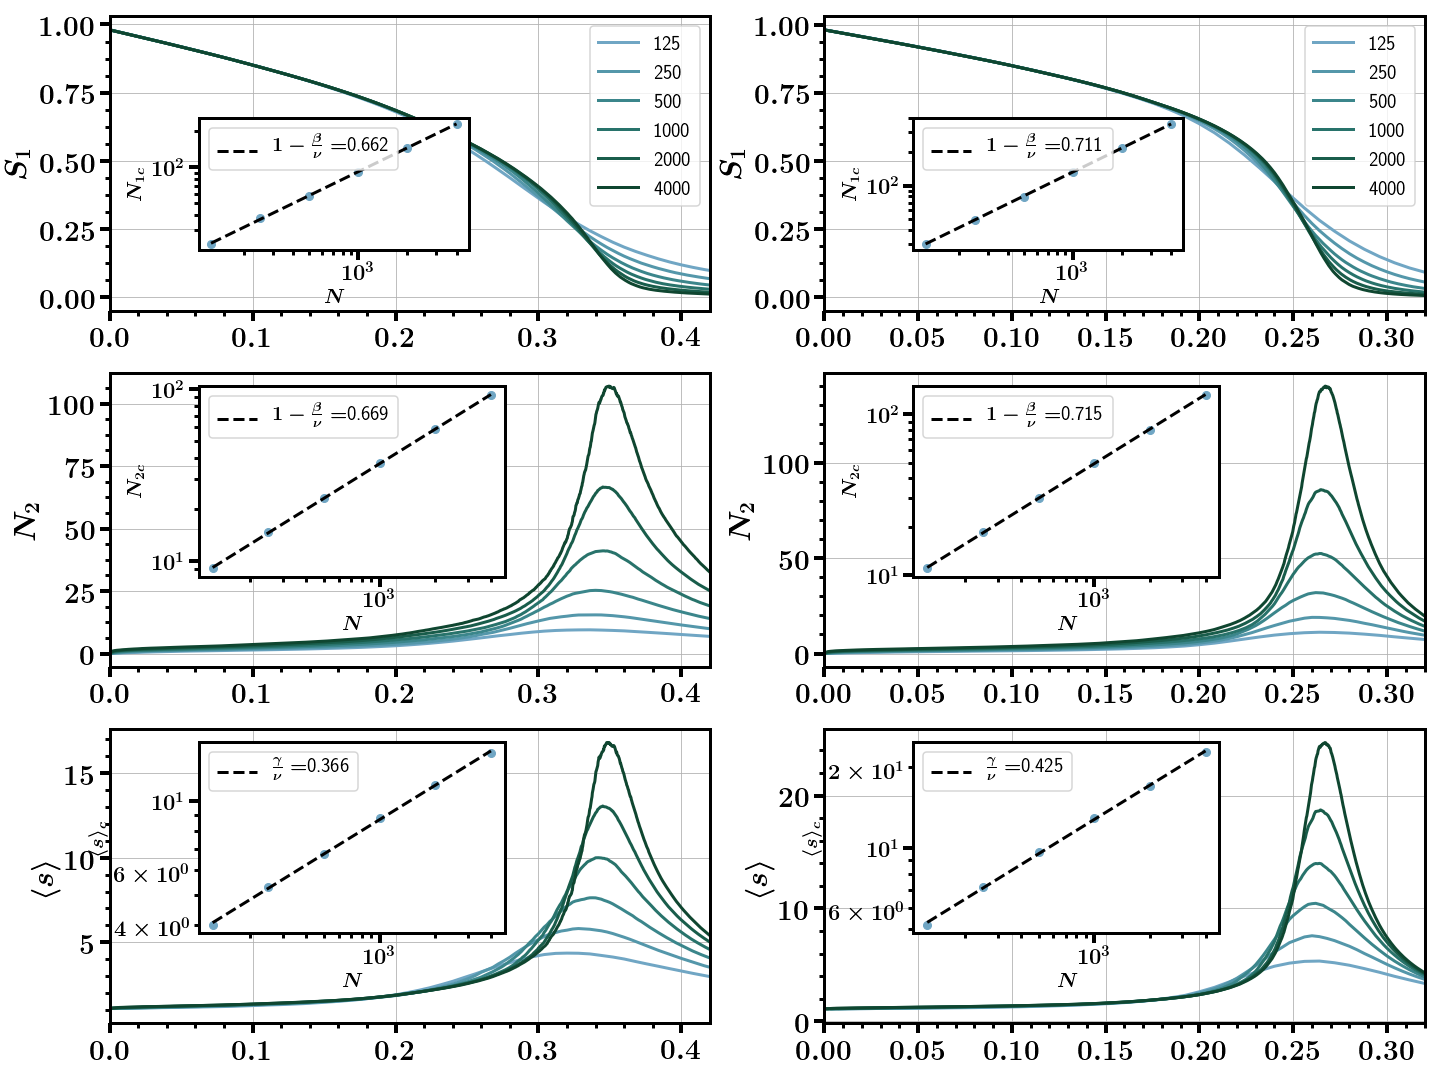

In [112]:
fcs = [0.362, 0.272]
fcs = [0.362, 0.272]
def plot_fig_fssa_deg(fcs):
    
    ncols = 2
    nrows = 3
    fig, axes = plt.subplots(figsize=(10*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
    _N_values = N_values

    attacks = ['Deg', 'DegU']
    for i, attack in enumerate(attacks):
        measures= ['meanS2', 'Nsec']
        peak_values = {}
        fc_values = {}
        measure_fc_values = {}
        for measure in measures:
            fc_values[measure], peak_values[measure] = get_fc_N(dfs, attack, _N_values, measure)
            #measure_fc_values[measure] = get_crit_measure_N(dfs, attack, _N_values, measure, fc_values[measure])
            measure_fc_values[measure] = get_crit_measure_N(dfs, attack, _N_values, measure, fcs[i])
        #measure_fc_values['Sgcc'] = get_crit_measure_N(dfs, attack, _N_values, 'Sgcc', fc_values['Nsec'])    
        measure_fc_values['Sgcc'] = get_crit_measure_N(dfs, attack, _N_values, 'Sgcc', fcs[i])    

        palette = sns.cubehelix_palette(
            n_colors=len(_N_values), start=2.0, rot=0.35, gamma=1.0, hue=1.0, light=0.6, dark=0.2,
        )
        plt.rc('axes', prop_cycle=cycler('color', palette))


        for ax in axes[:,0].flatten():
            ax.set_xlim(0., 0.42)
            ax.grid(True)  
        for ax in axes[:,1].flatten():
            ax.set_xlim(0., 0.32)
            ax.grid(True)

        ax = axes[0][i]
        for N in _N_values:
            ax.plot(dfs[attack][N]['t'], dfs[attack][N]['Sgcc'], label='{}'.format(N))
        ax.set_ylabel(r'$S_1$')
        ax.legend(loc='best', fontsize=20)

        ax = axes[1][i]
        for N in _N_values:
            ax.plot(dfs[attack][N]['t'], dfs[attack][N]['Nsec'])
        ax.set_ylabel(r'$N_2$')
        #ax.set_xlabel(r'$f$')
        
        ax = axes[2][i]
        for N in _N_values:
            ax.plot(dfs[attack][N]['t'], dfs[attack][N]['meanS2'])
        ax.set_ylabel(r'$\langle s \rangle $')
        
        if nrows > 3:
            ax = axes[3][i]
            for N in _N_values:
                ax.plot(dfs[attack][N]['t'], (N*dfs[attack][N]['Sgcc'])/dfs[attack][N]['Nsec'])
            ax.set_ylabel(r'$N_1/N_2$')
            ax.set_xlabel(r'$f$')        
            ax.set_ylim(0, 10)
            if i == 0:
                ax.set_xlim(0.3, 0.4)
            else:
                ax.set_xlim(0.25, 0.3)
            ax.axvline(fcs[i], color='k', linestyle='--')
            
        plot_inset(_N_values, 'Sgcc', axes[0][i], measure_fc_values)
        plot_inset(_N_values, 'Nsec', axes[1][i], measure_fc_values)
        plot_inset(_N_values, 'meanS2', axes[2][i], measure_fc_values)
        

    plt.tight_layout()
    plt.savefig('/home/nahuel-ofi/Desktop/fc.pdf')
    plt.show()
    

plot_fig_fssa_deg(fcs)

/media/nahuel-ofi/datos/d/anaconda3/envs/networks3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


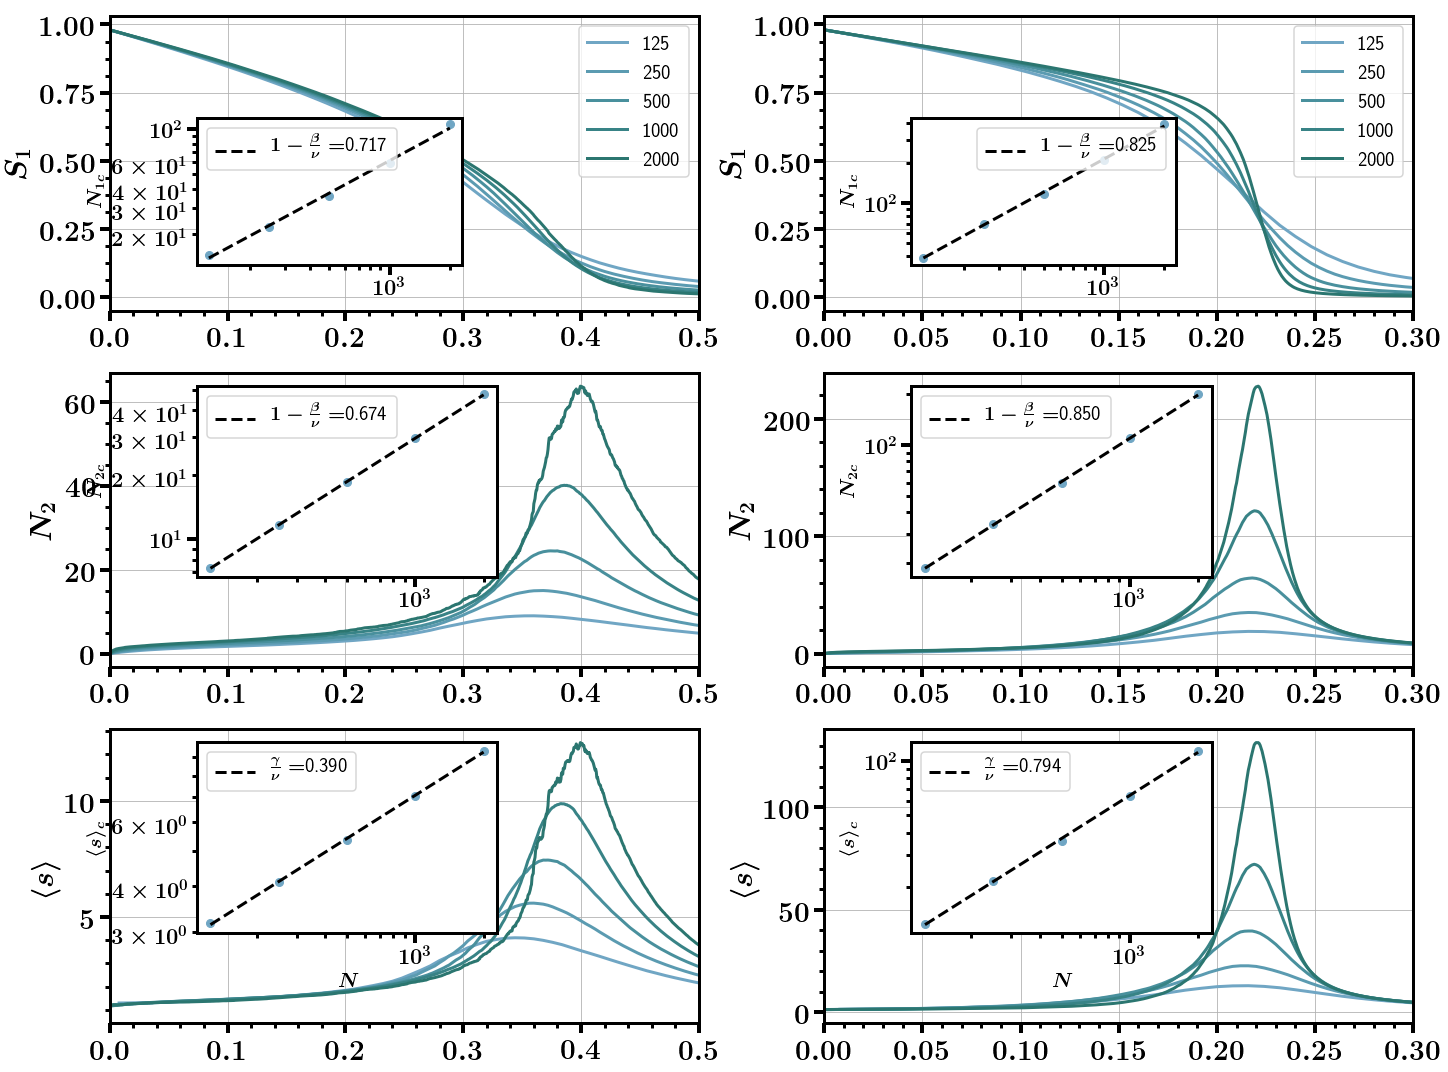

In [167]:
fcs = [0.425, 0.226]
def plot_fig_fssa_deg(fcs):
    
    ncols = 2
    nrows = 3
    fig, axes = plt.subplots(figsize=(10*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
    _N_values = N_values

    attacks = ['Btw', 'BtwU']
    for i, attack in enumerate(attacks):
        measures= ['meanS2', 'Nsec']
        peak_values = {}
        fc_values = {}
        measure_fc_values = {}
        for measure in measures:
            fc_values[measure], peak_values[measure] = get_fc_N(dfs, attack, _N_values, measure)
            #measure_fc_values[measure] = get_crit_measure_N(dfs, attack, _N_values, measure, fc_values[measure])
            measure_fc_values[measure] = get_crit_measure_N(dfs, attack, _N_values, measure, fcs[i])
        #measure_fc_values['Sgcc'] = get_crit_measure_N(dfs, attack, _N_values, 'Sgcc', fc_values['Nsec'])    
        measure_fc_values['Sgcc'] = get_crit_measure_N(dfs, attack, _N_values, 'Sgcc', fcs[i])    

        palette = sns.cubehelix_palette(
            n_colors=len(_N_values), start=2.0, rot=0.35, gamma=1.0, hue=1.0, light=0.6, dark=0.2,
        )
        plt.rc('axes', prop_cycle=cycler('color', palette))


        for ax in axes[:3,0].flatten():
            ax.set_xlim(0., 0.5)
            ax.grid(True)  
        for ax in axes[:3,1].flatten():
            ax.set_xlim(0., 0.3)
            ax.grid(True)

        ax = axes[0][i]
        for N in _N_values:
            ax.plot(dfs[attack][N]['t'], dfs[attack][N]['Sgcc'], label='{}'.format(N))
        ax.set_ylabel(r'$S_1$')
        ax.legend(loc='best', fontsize=20)

        ax = axes[1][i]
        for N in _N_values:
            ax.plot(dfs[attack][N]['t'], dfs[attack][N]['Nsec'])
        ax.set_ylabel(r'$N_2$')
        #ax.set_xlabel(r'$f$')
        
        ax = axes[2][i]
        for N in _N_values:
            ax.plot(dfs[attack][N]['t'], dfs[attack][N]['meanS2'])
        ax.set_ylabel(r'$\langle s \rangle $')
        
        if nrows > 3:
            ax = axes[3][i]
            for N in _N_values:
                ax.plot(dfs[attack][N]['t'], (N*dfs[attack][N]['Sgcc'])/dfs[attack][N]['Nsec'])
            ax.set_ylabel(r'$N_1/N_2$')
            ax.set_xlabel(r'$f$')        
            ax.set_ylim(1.5, 3)
            if i == 0:
                ax.set_xlim(0.4, 0.5)
            else:
                ax.set_xlim(0.2, 0.25)
            ax.axvline(fcs[i], color='k', linestyle='--')
            
        plot_inset(_N_values, 'Sgcc', axes[0][i], measure_fc_values)
        plot_inset(_N_values, 'Nsec', axes[1][i], measure_fc_values)
        plot_inset(_N_values, 'meanS2', axes[2][i], measure_fc_values)
        

    plt.tight_layout()
    plt.savefig('/home/nahuel-ofi/Desktop/btw_fssa_fc.pdf')
    plt.show()

plot_fig_fssa_deg(fcs)

# Suplemental material

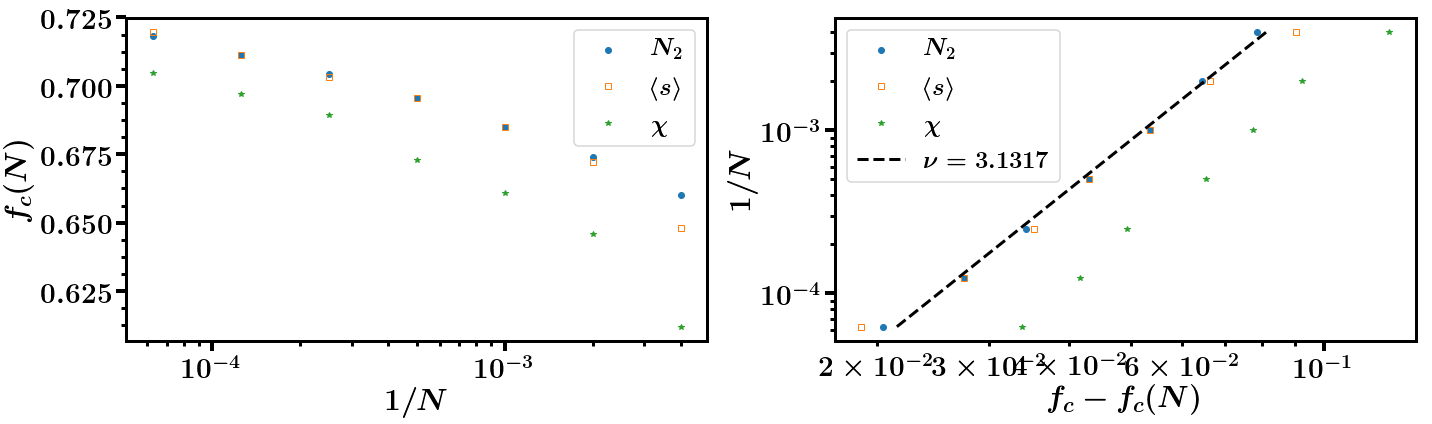

In [50]:
_N_values = N_values[1:-1]
fc_values = {}
measure_fc_values = {}
attack = 'Ran'
measures= ['meanS2', 'Nsec', 'varSgcc']
fc = compute_fc(dfs, attack, _N_values, min_f, max_f)
for measure in measures:
    fc_values[measure], _ = get_fc_N(dfs, attack, _N_values, measure)
    measure_fc_values[measure] = get_crit_measure_N(dfs, attack, _N_values, measure, fc_values[measure])
measure_fc_values['Sgcc'] = get_crit_measure_N(dfs, attack, _N_values, 'Sgcc', fc_values['Nsec'])   


plot_fc_N(_N_values, fc_values, attack, fc)

0.7355


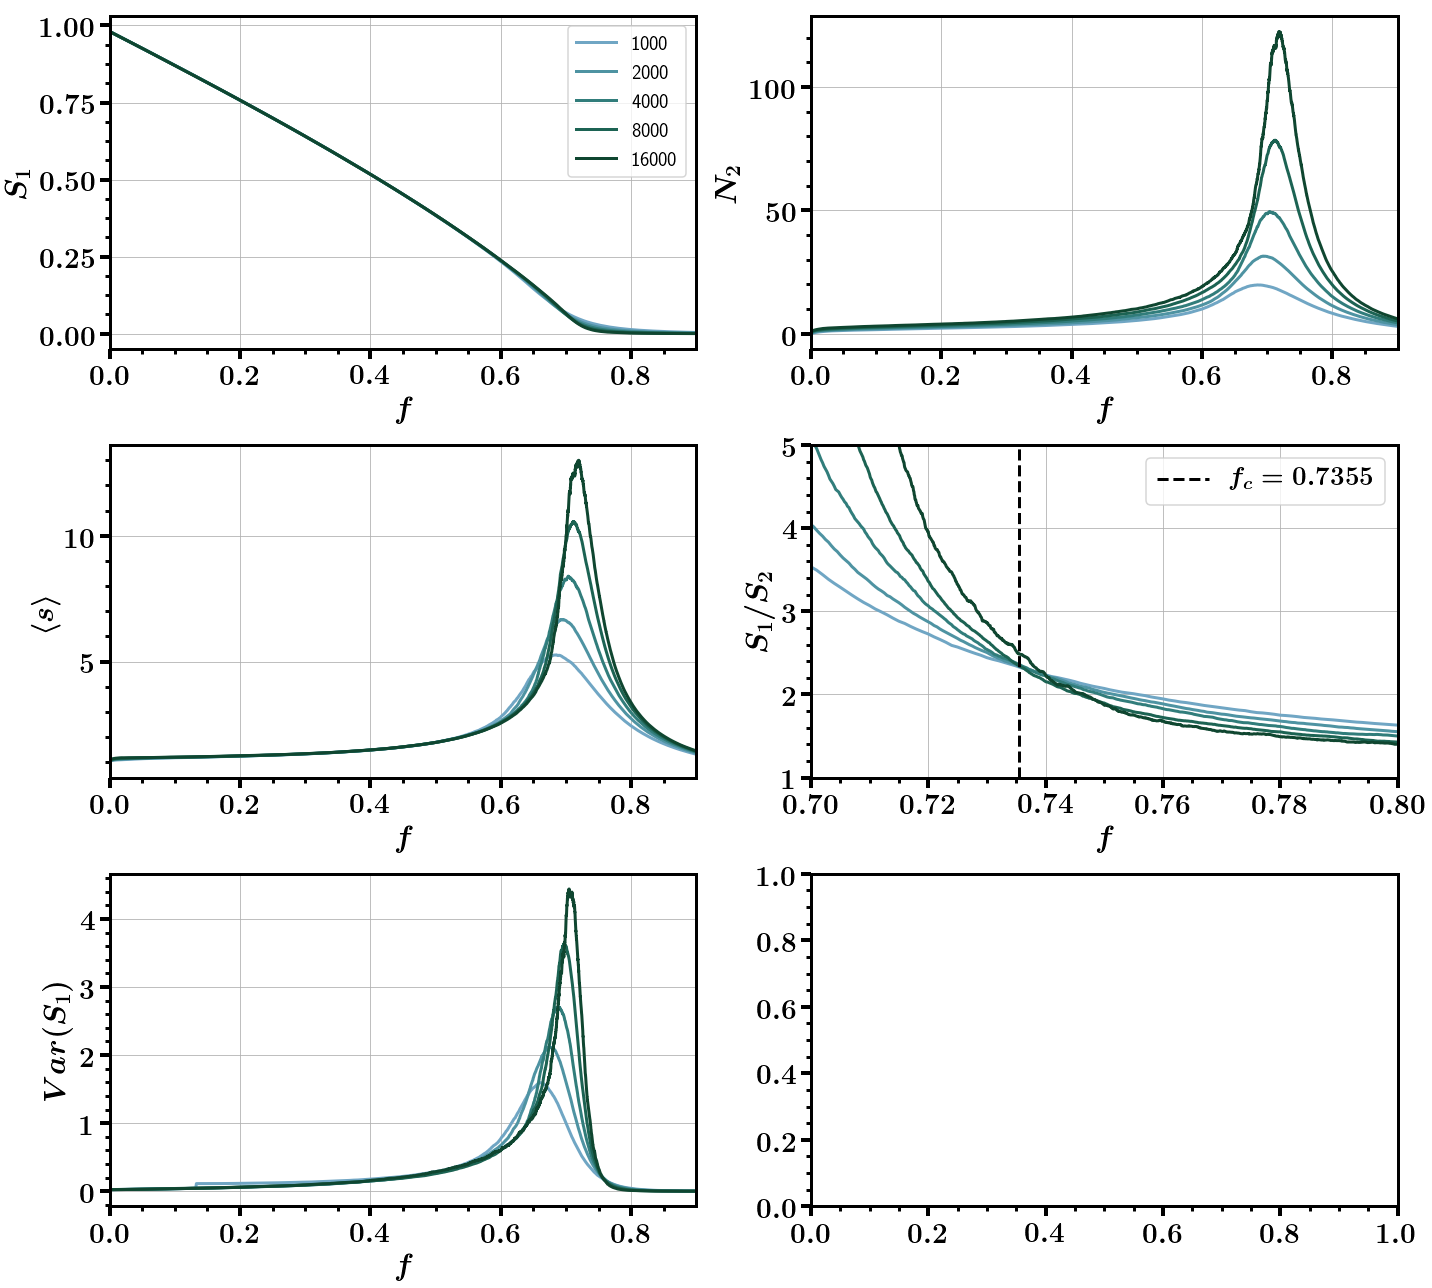

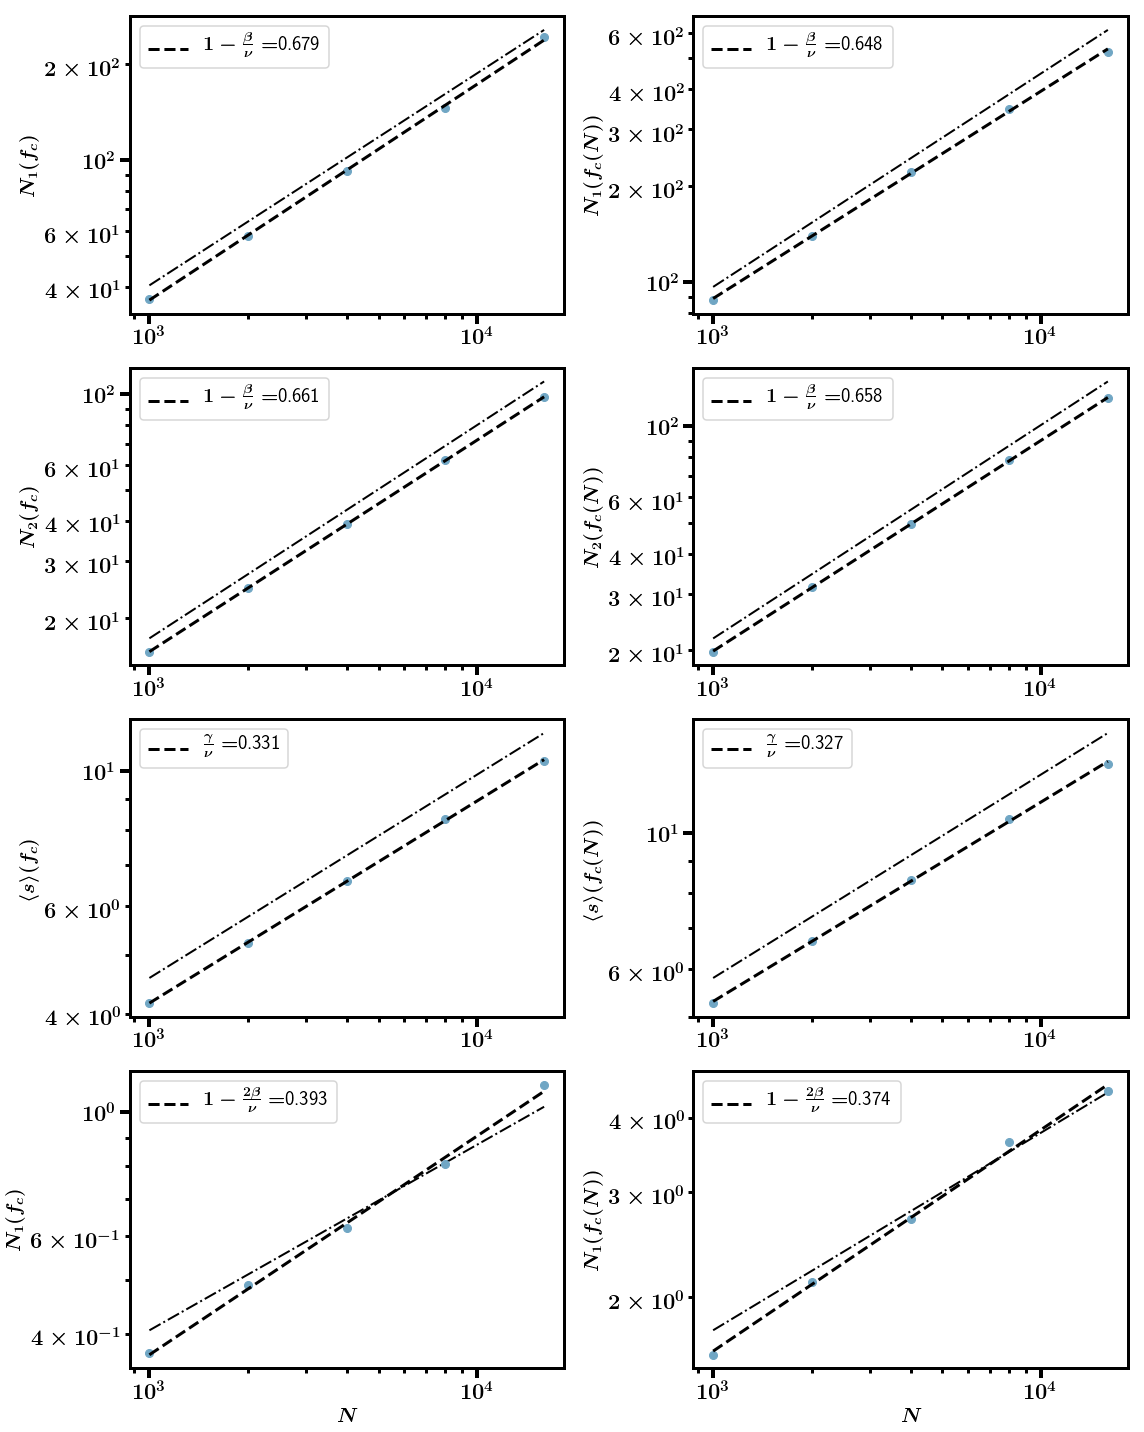

In [72]:
attack = 'Ran'
_N_values = N_values[3:-1]
#fc = 0.7359
fc = 0.7355
#fc = compute_fc(dfs, attack, N_values[:-3], min_f, max_f)
print(fc)

plot_fig2_ran(fc, _N_values)

measures= ['meanS2', 'Nsec', 'varSgcc']
peak_values = {}
fc_values = {}
measure_fc_values = {}
for measure in measures:
    fc_values[measure], peak_values[measure] = get_fc_N(dfs, attack, _N_values, measure)
    
ncols = 2
nrows = 4
fig, axes = plt.subplots(figsize=(8*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for measure in measures:
    measure_fc_values[measure] = get_crit_measure_N(dfs, attack, _N_values, measure, fc)
measure_fc_values['Sgcc'] = get_crit_measure_N(dfs, attack, _N_values, 'Sgcc', fc)  
plot_fc_scaling(_N_values, 'Sgcc', axes[0][0], measure_fc_values, peak=False)
plot_fc_scaling(_N_values, 'Nsec', axes[1][0], measure_fc_values, peak=False)
plot_fc_scaling(_N_values, 'meanS2', axes[2][0], measure_fc_values, peak=False)
plot_fc_scaling(_N_values, 'varSgcc', axes[3][0], measure_fc_values, peak=False)

for measure in measures:
    measure_fc_values[measure] = get_crit_measure_N(dfs, attack, _N_values, measure, fc_values[measure])
measure_fc_values['Sgcc'] = get_crit_measure_N(dfs, attack, _N_values, 'Sgcc', fc_values['Nsec'])    
plot_fc_scaling(_N_values, 'Sgcc', axes[0][1], measure_fc_values, peak=True)
plot_fc_scaling(_N_values, 'Nsec', axes[1][1], measure_fc_values, peak=True)
plot_fc_scaling(_N_values, 'meanS2', axes[2][1], measure_fc_values, peak=True)
plot_fc_scaling(_N_values, 'varSgcc', axes[3][1], measure_fc_values, peak=True)
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'ran_fssa_exponents')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [12]:
def compute_fc(dfs, attack, N_values, min_f, max_f):

    N1_over_N2 = {}
    for N in N_values:
        N1_over_N2[N] = ((N*dfs[attack][N]['Sgcc'])/dfs[attack][N]['Nsec']).values

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[attack][max_N]['t'][mask].values
    
    s = np.zeros(n_values)
    for Na in N_values:
        for Nb in N_values:
            if Nb <= Na:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[attack][Na]['t'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[attack][Nb]['t'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
        
    fc = min_f + np.argmin(s)/max_N
    return fc

min_f = 0.7
max_f = 0.8
_N_values = N_values[:-1]
compute_fc(dfs, attack, _N_values, min_f, max_f)

0.7384999999999999

In [64]:
N_values.index(1000)

3

In [71]:
def plot_fig2_ran(fc, N_values):
    
    ncols = 2
    nrows = 3
    fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)
    
    attack = 'Ran'
    
    palette = sns.cubehelix_palette(
        n_colors=len(_N_values), start=2.0, rot=0.35, gamma=1.0, hue=1.0, light=0.6, dark=0.2,
    )
    plt.rc('axes', prop_cycle=cycler('color', palette))

    for ax in axes.flatten()[:-1]:
        ax.set_xlim(0., 0.90)
        ax.grid(True)  

    ax = axes[0][0]
    for N in _N_values:
        ax.plot(dfs[attack][N]['t'], dfs[attack][N]['Sgcc'], label='{}'.format(N))
    ax.set_ylabel(r'$S_1$')
    ax.legend(loc='best', fontsize=20)
    ax.set_xlabel(r'$f$')
    
    ax = axes[0][1]
    for N in _N_values:
        ax.plot(dfs[attack][N]['t'], dfs[attack][N]['Nsec'])
    ax.set_ylabel(r'$N_2$')
    ax.set_xlabel(r'$f$')
    
    ax = axes[1][0]
    for N in _N_values:
        ax.plot(dfs[attack][N]['t'], dfs[attack][N]['meanS2'])
    ax.set_ylabel(r'$\langle s \rangle $')
    ax.set_xlabel(r'$f$')
    
    ax = axes[2][0]
    for N in _N_values:
        ax.plot(dfs[attack][N]['t'], dfs[attack][N]['varSgcc'])
    ax.set_ylabel(r'$Var(S_1)$')
    ax.set_xlabel(r'$f$')
    
    ax = axes[1][1]
    for N in _N_values:
        ax.plot(dfs[attack][N]['t'], (N*dfs[attack][N]['Sgcc'])/dfs[attack][N]['Nsec'])
    ax.set_ylabel(r'$S_1/S_2$')
    ax.set_xlabel(r'$f$')        
    ax.set_ylim(1, 5)
    ax.set_xlim(0.7, 0.8)
    ax.axvline(fc, color='k', linestyle='--', label=r'$f_c = {{{:.4f}}}$'.format(fc))
    ax.legend(loc='best')
    
    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'ran_fssa_fc')
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')
    plt.show()
    
def plot_fc_scaling(N_values, measure, ax, measure_fc_values, peak):
    
    def powerlaw(X, a, c):
        return c*np.array(X)**a
    
    
    Y_pred, slope = getLinearReg(N_values, measure_fc_values[measure])
    
    if measure == 'Nsec':
        label = r'$1 - \frac{\beta}{\nu} = $' + '{:.3f}'.format(slope)
        if peak:
            ylabel = r'$N_{2}(f_c(N))$'
        else:
            ylabel = r'$N_{2}(f_c)$'
        a = 0.666666
        c = 1.1*measure_fc_values[measure][0]/N_values[0]**a
        ax.plot(N_values, powerlaw(N_values, a, c), '-.', color='k', linewidth=2)
    if measure == 'meanS2':
        label = r'$\frac{\gamma}{\nu} = $' + '{:.3f}'.format(slope)
        if peak:
            ylabel = r'$\langle s \rangle(f_c(N))$'
        else:
            ylabel = r'$\langle s \rangle(f_c)$'
        a = 0.333333
        c = 1.1*measure_fc_values[measure][0]/N_values[0]**a
        ax.plot(N_values, powerlaw(N_values, a, c), '-.', color='k', linewidth=2)
    if measure == 'Sgcc':
        label = r'$1 - \frac{\beta}{\nu} = $' + '{:.3f}'.format(slope)
        if peak:
            ylabel = r'$N_{1}(f_c(N))$'
        else:
            ylabel = r'$N_{1}(f_c)$'
        a = 0.666666
        c = 1.1*measure_fc_values[measure][0]/N_values[0]**a
        ax.plot(N_values, powerlaw(N_values, a, c), '-.', color='k', linewidth=2)   
        
    if measure == 'varSgcc':
        label = r'$1-\frac{2\beta}{\nu} = $' + '{:.3f}'.format(slope)
        if peak:
            ylabel = r'$N_{1}(f_c(N))$'
        else:
            ylabel = r'$N_{1}(f_c)$'
        a = 0.333333
        c = 1.1*measure_fc_values[measure][0]/N_values[0]**a
        ax.plot(N_values, powerlaw(N_values, a, c), '-.', color='k', linewidth=2)
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(which='major', labelsize=22)
    ax.tick_params(which='minor', labelsize=22)
    ax.plot(N_values, measure_fc_values[measure], 'o', markersize=8)    
    ax.plot(N_values, Y_pred, '--', color='k', linewidth=3, label=label)
    ax.legend(loc='best', fontsize=20) 
    if measure == 'varSgcc':
        ax.set_xlabel(r'$N$', fontsize=20) 
    else:
        ax.set_xlabel('') 
    ax.set_ylabel(ylabel, fontsize=20)

In [43]:
def plot_fc_N(N_values, fc_values, attack, fc):
    ncols = 2
    nrows = 1
    fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

    ax = axes[0]
    ax.set_xscale('log')
    ax.set_xlabel(r"$1/N$") 
    ax.plot(1/np.array(N_values), fc_values['Nsec'], 'o', color=colors[0], label=r'$N_{2}$')
    ax.plot(1/np.array(N_values), fc_values['meanS2'], 's', color=colors[1], 
            label=r"$\langle s \rangle $", markerfacecolor='none')
    ax.plot(1/np.array(N_values), fc_values['varSgcc'], '*', color=colors[2], 
            label=r"$\chi $")
    #ax.plot(fc_values['Nsec'], 1/np.array(N_values), 'o', color=colors[0], label=r'$N_{2}$')
    #ax.plot(fc_values['meanS2'], 1/np.array(N_values), 's', color=colors[1], 
    #       label=r"$\langle s \rangle $", markerfacecolor='none')
    ax.set_ylabel(r'$f_c(N)$')
    ax.legend(loc='best', fontsize=24)

    
    ax = axes[1]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r"$1/N$") 
    X = (1/np.array(N_values))
    ax.plot(fc-fc_values['Nsec'], X, 'o', color=colors[0], label=r'$N_{2}$')
    ax.plot(fc-fc_values['meanS2'], X, 's', color=colors[1], 
            label=r"$\langle s \rangle $", markerfacecolor='none')
    ax.plot(fc-fc_values['varSgcc'], X, '*', color=colors[2], 
            label=r"$\chi $")
    ax.set_xlabel(r'$f_c-f_c(N)$')
    
    linear_regressor = LinearRegression()
    X = np.log(np.array(N_values)).reshape(-1, 1)
    Y = np.log(fc-fc_values['Nsec']).reshape(-1, 1)
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    slope = linear_regressor.coef_[0][0]
    r2 = linear_regressor.score(X, Y)
    nu = -1/slope

    ax.plot(np.exp(Y_pred), 1/np.exp(X), '--', color='k', label=r'$\nu = {{{:.4f}}}$'.format(nu))
    ax.legend(loc='best', fontsize=24)

    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'fc_{}'.format(attack))
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')
    plt.show()
    

In [112]:
linear_regressor = LinearRegression()
fc_estimated = np.linspace(0.73, 0.753, 10)
for i, fc in enumerate(fc_estimated):
    X = np.log(np.array(_N_values).reshape(-1, 1))
    Y = np.log(fc-fc_values['Nsec'].reshape(-1, 1))
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    slope = linear_regressor.coef_[0][0]
    r2 = linear_regressor.score(X, Y)
    print('{:.5f}\t{:.4f}\t{:.4f}\t{:.6f}'.format(fc, slope, 1/slope, r2))

0.73000	-0.3943	-2.5360	0.995662
0.73256	-0.3649	-2.7406	0.996975
0.73511	-0.3398	-2.9431	0.997885
0.73767	-0.3181	-3.1438	0.998517
0.74022	-0.2991	-3.3431	0.998953
0.74278	-0.2824	-3.5413	0.999247
0.74533	-0.2675	-3.7385	0.999437
0.74789	-0.2541	-3.9350	0.999552
0.75044	-0.2421	-4.1307	0.999609
0.75300	-0.2312	-4.3259	0.999623


In [4]:
#attacks = ['BtwU', 'DegU', 'Ran', 'Deg', 'Btw']
attacks = ['Ran']

N_values = [32000]
p_values = [0.000125]
dfs = {}
for attack in attacks:
    dfs[attack] = {}
    for N, p in zip(N_values, p_values):

        network_base = 'ER_N{}_p{}'.format(N, p)
        
        csv_file_name = os.path.join(net_dir_name, network_base, '{}_cpp.csv'.format(attack))    
        df = pd.read_csv(csv_file_name, index_col=0)
        dfs[attack]['cpp'] = df

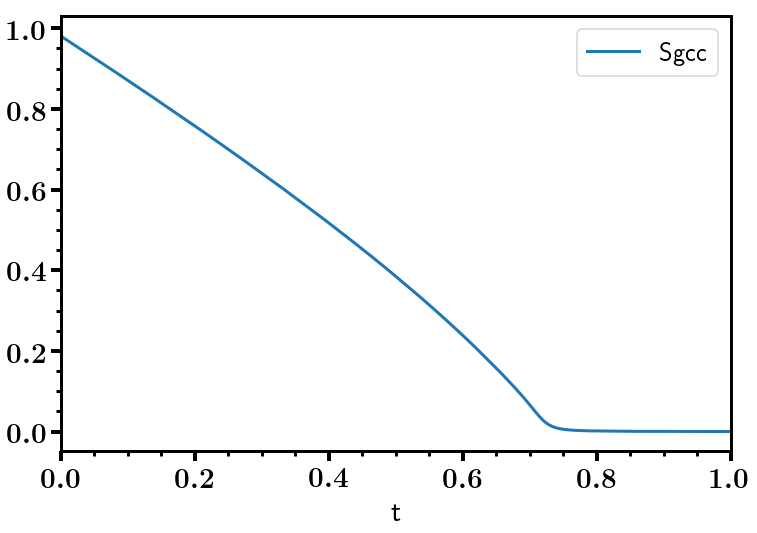

In [6]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
dfs['Ran']['cpp'].plot(x='t', y='Sgcc', ax=ax)

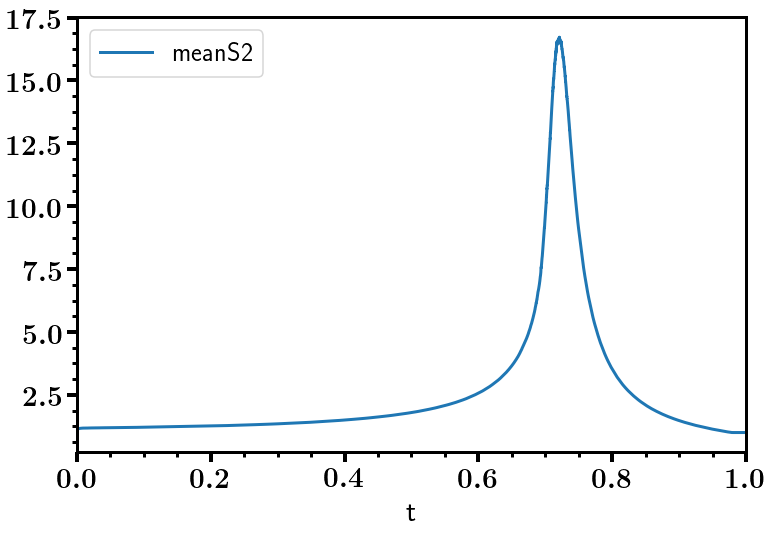

In [7]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
dfs['Ran']['cpp'].plot(x='t', y='meanS2', ax=ax)


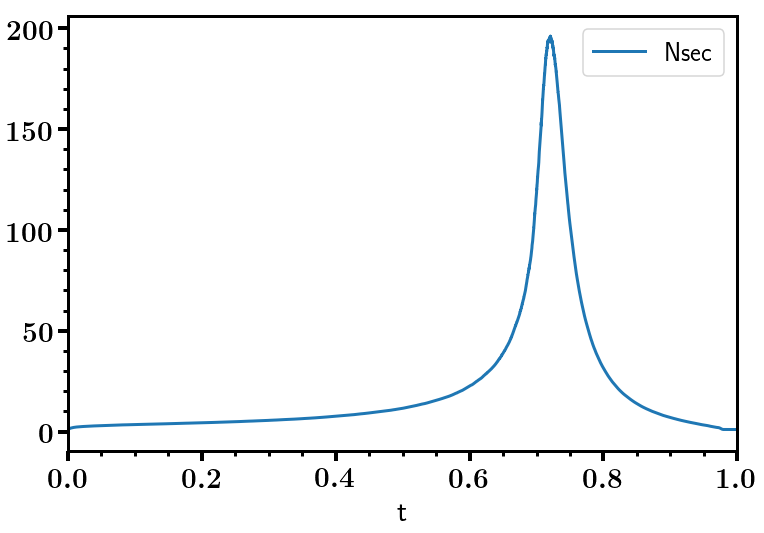

In [9]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
dfs['Ran']['cpp'].plot(x='t', y='Nsec', ax=ax)

In [25]:
N = 32000
full_file_name = '../networks/ER/ER_N32000_p0.000125/ER_N32000_p0.000125_00000/Ran/comp_data.txt'
aux = np.loadtxt(full_file_name, dtype=float)

_Ngcc_values = np.append(aux[:,0][::-1], np.repeat(1, (N-len(aux[:,0]))))
_Nsec_values = np.append(aux[:,1][::-1], np.repeat(1, (N-len(aux[:,1]))))
_meanS2_values = np.append(aux[:,2][::-1], np.repeat(1, (N-len(aux[:,2]))))
t_values = np.arange(N) / N

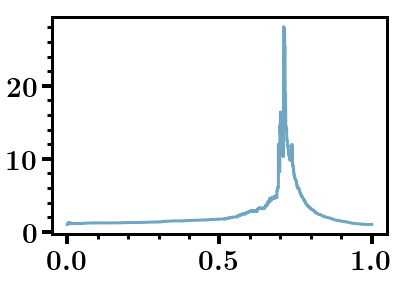

In [28]:
plt.plot(t_values, _meanS2_values)

In [33]:
dfs['Ran']

{125:          t      Sgcc   varSgcc      Nsec    meanS2    binder
 0    0.000  0.980683  0.022356  0.000000       NaN  0.666421
 1    0.008  0.971992  0.023305  0.083140  1.099245  0.666406
 2    0.016  0.963296  0.024189  0.161282  1.098137  0.666392
 3    0.024  0.954579  0.025017  0.235645  1.099408  0.666377
 4    0.032  0.945843  0.026053  0.304645  1.101706  0.666360
 5    0.040  0.937120  0.026977  0.367914  1.100591  0.666343
 6    0.048  0.928350  0.028081  0.432768  1.102598  0.666323
 7    0.056  0.919539  0.029160  0.494575  1.107571  0.666303
 8    0.064  0.910739  0.030603  0.547970  1.109796  0.666278
 9    0.072  0.901908  0.031823  0.604291  1.113943  0.666255
 10   0.080  0.893053  0.032980  0.657808  1.116973  0.666231
 11   0.088  0.884163  0.034278  0.709497  1.121190  0.666206
 12   0.096  0.875270  0.035656  0.758015  1.122018  0.666177
 13   0.104  0.866414  0.037068  0.799951  1.126653  0.666148
 14   0.112  0.857486  0.038939  0.837620  1.127916  0.666110
 15